In [1]:
# import libraries 
from pathlib import Path
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

sns.set_theme()

plt.rcParams['figure.figsize'] = [10, 8]

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
###################################

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import FluoSpecModel from fluospec package's module model
# FluoSpecModel is a class containing generative model and eventual helper methods
from fluospec.model import FluoSpecModel, Prediction, SimulateFluoSpec
# import data loading helper
from fluospec.data_io import load_data

# 2. Generative model:
For atomic and molecular lineshape models, theory describes that in the absence of external broadening mechanisms,  the intensity profile of the fluorescence of atoms and molecules is given by a Lorentzian line shape:
$$ I(f) = A \frac{\Gamma^2/4}{(f - f_0)^2 + \Gamma^2/4}$$
where $A$ is the amplitude, $f_0$ is the center frequency of the fluorescence and $\Gamma$ is the decay rate of the transition (also the full width at half maximum). We assume that any broadening we later add is a function of the linewidth, Doppler broadening, plus any additional width imparted by the camera. 

In our data, we have a background that is linear with the frequency which can be modeled by a linear equation as given below. This drift can be explained as a frequency dependent intensity shift which the camera experiences, such that the camera is more sensitive to increasing frequency.

$$ I_b(f) = mf + b$$
such that the full model is 
$$I_T(f) = I(f) + I_b(f) = A \frac{\Gamma^2/4}{(f - f_0)^2 + \Gamma^2/4} + (mf + b)$$

Noise on the camera is fairly complex, but data points are averaged, so that the noise on the camera can be characterized as Gaussian with $\sigma$ = 0.2, thus:
$$ y_i \sim \text{normal}(\mu_i = I_T(f_i) ,\sigma_i = 0.2)$$

In addition to the lineshape model, we can add a parameter that accounts for the power broadening of the lineshape: 

$$I_T(f) = I(f) + I_b(f) = A \frac{\Gamma^2/4}{(f - f_0)^2 + \Gamma^2/4\left(1+\frac{I}{I_{\text{sat}}}\right)} + (mf + b)$$

Lastly we will use gamma (for positive parameters) and normal priors since our bounds aren't well defined:

$$A \sim \text{gamma}(\mu = 0.2,\sigma = 0.1)$$

$$f_0 \sim \text{gamma}(\mu = 290, \sigma = 10)$$

$$\Gamma \sim \text{gamma}(\mu = 0.5,\sigma = 0.1)$$

$$ \frac{I}{I_{\text{sat}}} \sim \text{gamma}(\mu = 0.5,\sigma = 0.1)$$

$$m \sim \text{normal}(\mu = 0.05,\sigma = 0.01)$$

$$b \sim \text{normal}(\mu = 1,\sigma = 0.2)$$

Thus the full statistical model is:
$$ y_i \sim \text{normal}(\mu_i = I_T(f_i) ,\sigma_i = 0.2)\\A \sim \text{gamma}(5,1) \\f_0 \sim \text{gamma}(20,4)\\\Gamma \sim \text{gamma}(5,1)\\\frac{I}{I_{\text{sat}}} \sim \text{gamma}(0.5, 0.1)\\m \sim \text{normal}(0.05,0.1)\\b \sim \text{normal}(2,0.4)$$


# 3. Simulation of data:
We begin by loading our simulated data, generated with the means of the priors above with added Gaussian noise. 

In [3]:
# load simulated data from pickle or csv
sim_data = load_data(Path('./fluospec/sim_data/fluospec_sim_data.pkl'))

sim_data = SimulateFluoSpec.init_with_defaults().generate_sim_data()

# define some more data vectors for convenience
sim_w = sim_data.w
sim_I = sim_data.I
sim_sigma_I = sim_data.sigma_I

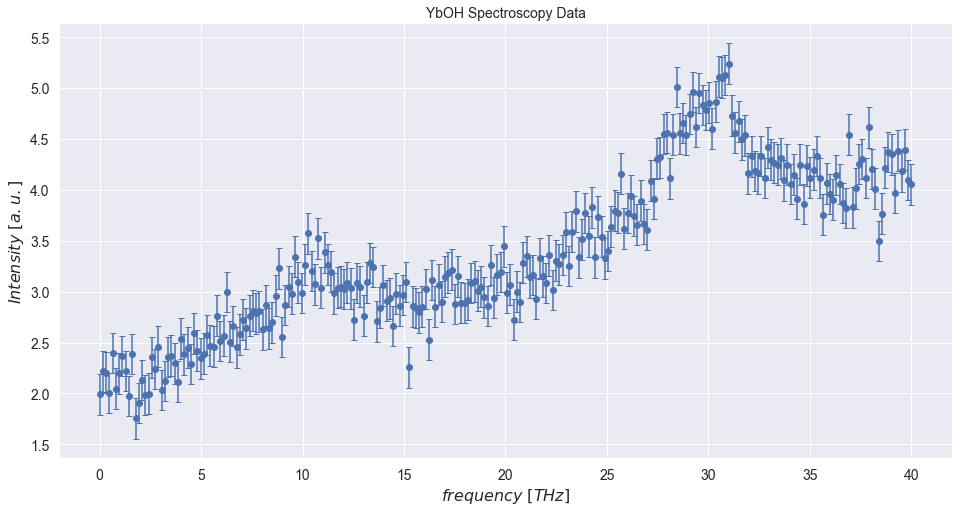

In [4]:
plt.figure(figsize=(16, 8))
plt.errorbar(sim_w, sim_I, yerr=sim_sigma_I, fmt='o', capsize=3)
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('YbOH Spectroscopy Data');

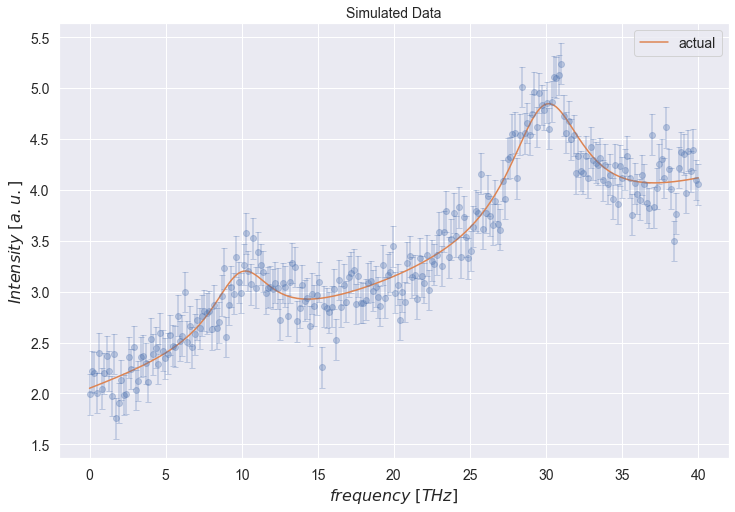

In [5]:
plt.figure(figsize=(12,8))
plt.errorbar(sim_w, sim_I, yerr=sim_sigma_I, fmt='o', capsize=3, alpha=.3)
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('Simulated Data');

# A_inf = summary['mean']['A']
# w0_inf = summary['mean']['w0']
# gamma_inf = summary['mean']['gamma']
# intensity_ratio_inf = summary['mean']['intensity_ratio']
# m_inf = summary['mean']['m']
# b_inf = summary['mean']['b']

w_inf = np.linspace(sim_data.w.min(), sim_data.w.max(), 250)

prediction_w_actual = Prediction.init_with_defaults().prediction(w_inf)

# prediction_inferred = Prediction(A_inf, w0_inf, gamma_inf, intensity_ratio_inf, m_inf, b_inf).prediction(w_inf)

plt.plot(w_inf, prediction_w_actual, label='actual')
# plt.plot(w_inf, prediction_inferred, label='inferred')
plt.legend();

# How to use `fluospec`

To use the main class of `fluospec`, `FluoSpecModel`, we first instantiate it. Internally, `FluoSpecModel` implements the priors as given above. In order to instantiate the class, one initializes `FluoSpecModel` with tuples of `(mean, std)` for each prior. Use `FluoSpecModel?` for the exact ordering or the names of the arguments. Alternatively, define a dictionary with keys `<PARAMETER>_prior_params` and items `(<mean>, <std>)`, and use dictionary expansion to instantiate `FluoSpecModel`. After instantiation, one can change these parameters using `<INSTANCE_NAME>.<PARAMETER>_prior_params`.

Next, we call the `model` method, with a pandas DataFrame of the data as a parameter. This method will return a pymc3 Model that we can then use for inference. `model` expects the data as loaded by `load_data` (*ie* with the `w`, `I`, and `sigma_I` columns).

In [8]:
model_prior_params = {
                      'A_prior_params': [(2, 1), (1, 1)],
                      'w0_prior_params': [(30, 2), (10, 2)],
                      'gamma_prior_params': [(5, 1), (4, .5)],
                      'intensity_ratio_prior_params': [(.5, .1), (.5, .1)],
                      'm_prior_params': (.01, .01),
                      'b_prior_params': (2, .04),
                      }
        # theta = {'A': [2, 1],
        #          'w0': [20, 10],
        #          'gamma': [5, 4],
        #          'intensity_ratio': [.5, .5],
        #          'm': .05,
        #          'b': 2}

fluospec_model_instance = FluoSpecModel(**model_prior_params)

# print what the mean and std on the m parameter are
print(f"mean, std of m parameter: {fluospec_model_instance.m_prior_params}")

# Let's change it to (.05, .01)
fluospec_model_instance.m_prior_params = (.05, .01)
print(f"mean, std of m parameter after changing: {fluospec_model_instance.m_prior_params}")

mean, std of m parameter: (0.01, 0.01)
mean, std of m parameter after changing: (0.05, 0.01)


([A_0 ~ Gamma, A_1 ~ Gamma], [w0_0 ~ Gamma, w0_1 ~ Gamma], [gamma_0 ~ Gamma, gamma_1 ~ Gamma], [intensity_ratio_0 ~ Gamma, intensity_ratio_1 ~ Gamma], m ~ Normal, b ~ Normal)
[A_0 ~ Gamma, A_1 ~ Gamma]
<class 'theano.tensor.var.TensorVariable'>
Elemwise{add,no_inplace}.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, intensity_ratio_1, gamma_1, w0_1, A_1, intensity_ratio_0, gamma_0, w0_0, A_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


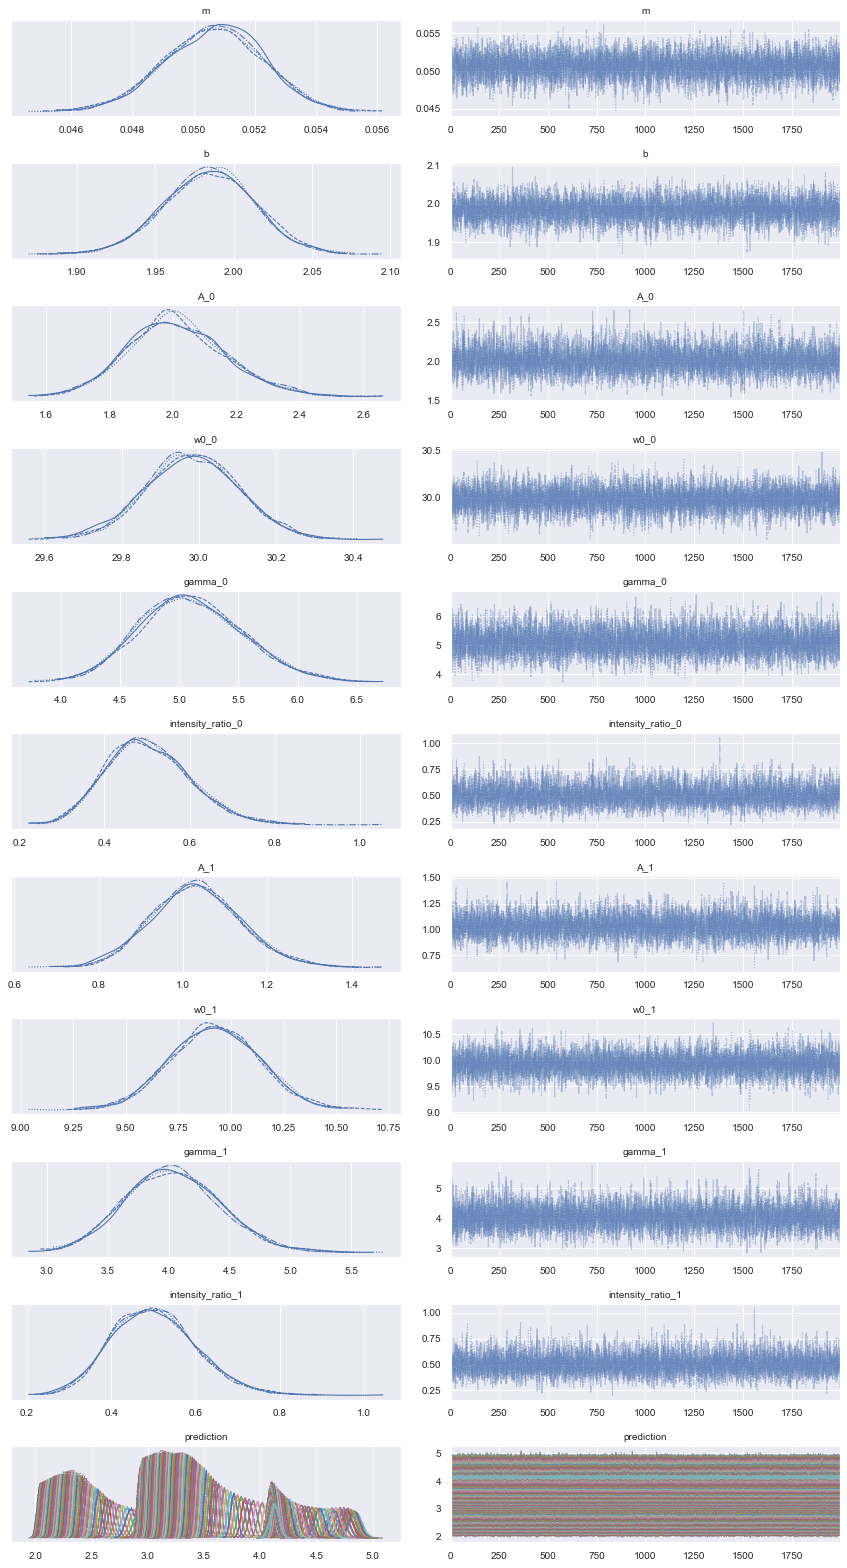

In [9]:
generative_model = fluospec_model_instance.model(sim_data)

with generative_model:
    trace = pm.sample(return_inferencedata=True, tune=1000, draws=2000)
    az.plot_trace(trace)
    plt.tight_layout()
    
posterior = trace.posterior.to_dataframe()

In [8]:
sns.pairplot(posterior.drop('prediction', axis=1))

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001A90BC7E3A0> (for post_execute):


KeyboardInterrupt: 

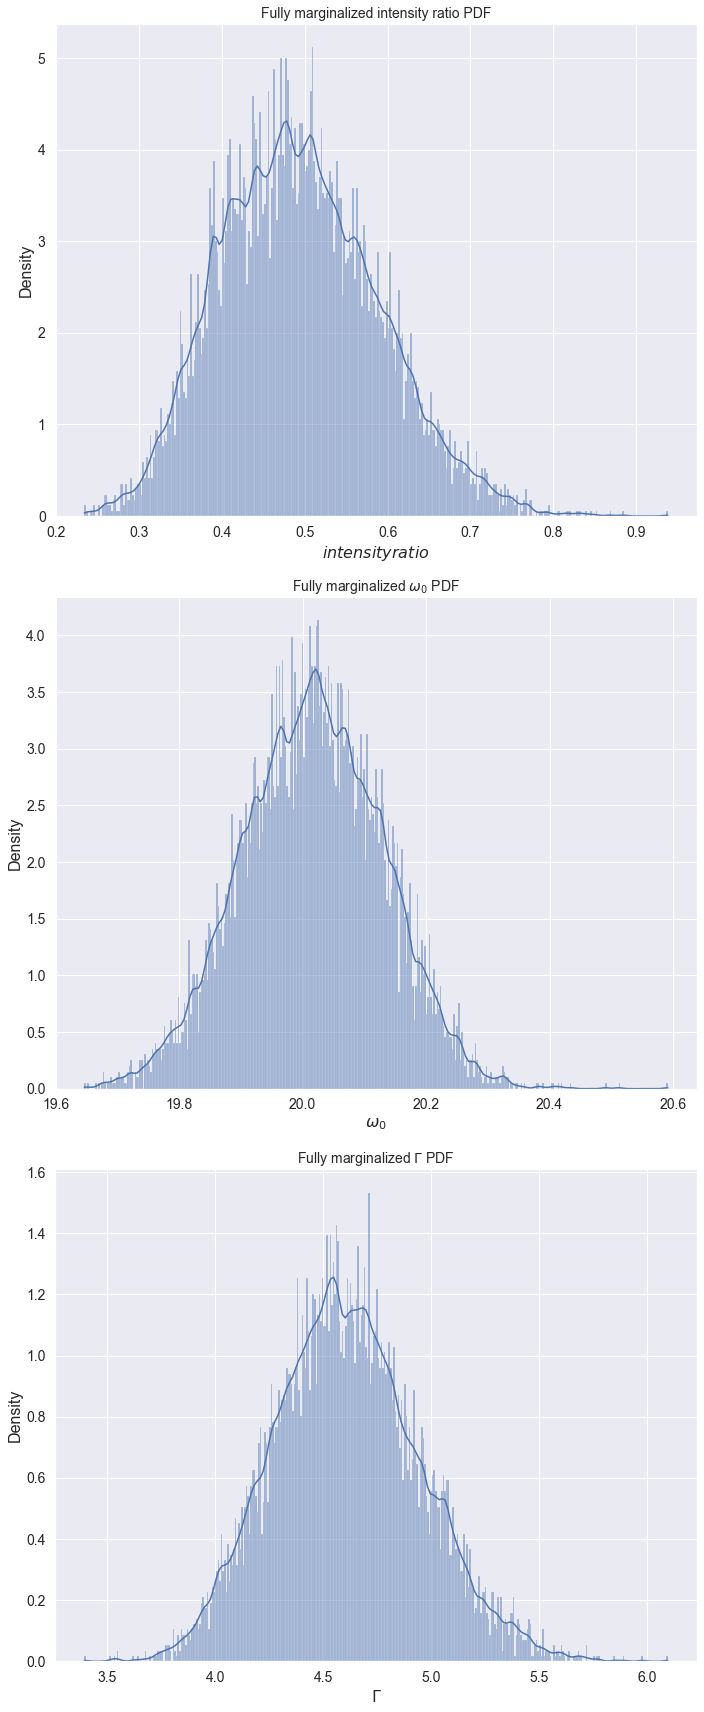

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 24))

marg_intensity_ratio = sns.histplot(posterior.intensity_ratio,
                                    fill=True, stat="density",
                                    kde=True,
                                    ax=ax1
                                    )
marg_intensity_ratio.set(xlabel='$intensity ratio$',
                         title='Fully marginalized intensity ratio PDF'
                         );


marg_w0 = sns.histplot(posterior.w0,
                       fill=True, stat="density",
                       kde=True,
                       ax=ax2
                      )
marg_w0.set(xlabel='$\omega_0$',
            title='Fully marginalized $\omega_0$ PDF'
            );

marg_gamma = sns.histplot(posterior.gamma,
                          fill=True, stat="density",
                          kde=True,
                          ax=ax3
                         )
marg_gamma.set(xlabel='$\Gamma$',
               title='Fully marginalized $\Gamma$ PDF'
               );

plt.tight_layout()

In [10]:
summary = az.summary(trace, hdi_prob=.95)[0:11]
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.051,0.002,0.047,0.054,0.000,0.000,6654.0,6080.0,1.0
b,1.984,0.029,1.926,2.039,0.000,0.000,7749.0,5185.0,1.0
A_0,2.014,0.157,1.704,2.325,0.002,0.001,6794.0,5199.0,1.0
w0_0,29.983,0.119,29.768,30.239,0.001,0.001,9001.0,5267.0,1.0
gamma_0,5.103,0.437,4.283,5.976,0.005,0.004,7179.0,5778.0,1.0
intensity_ratio_0,0.504,0.098,0.320,0.698,0.001,0.001,6559.0,5710.0,1.0
A_1,1.032,0.105,0.825,1.239,0.001,0.001,7192.0,5264.0,1.0
w0_1,9.924,0.210,9.525,10.340,0.002,0.002,9293.0,5937.0,1.0
gamma_1,4.036,0.393,3.267,4.785,0.004,0.003,8466.0,5115.0,1.0
intensity_ratio_1,0.502,0.100,0.312,0.698,0.001,0.001,8538.0,5807.0,1.0


# Comparison
Let's see how our inference did by comparing the real curve to the one from the inferred parameters.

NameError: name 'summary' is not defined

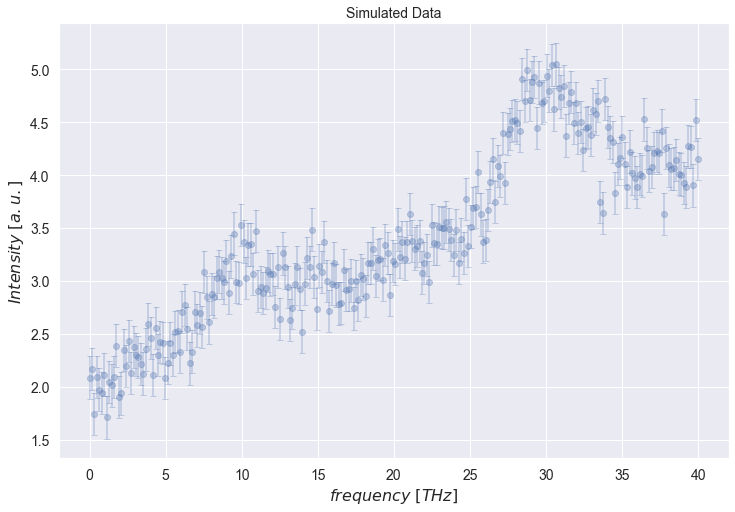

In [6]:
plt.figure(figsize=(12,8))
plt.errorbar(sim_w, sim_I, yerr=sim_sigma_I, fmt='o', capsize=3, alpha=.3)
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('Simulated Data');

A_inf = summary['mean']['A_0']
w0_inf = summary['mean']['w0_0']
gamma_inf = summary['mean']['gamma_0']
intensity_ratio_inf = summary['mean']['intensity_ratio_0']

A_inf0 = summary['mean']['A_1']
w0_inf0 = summary['mean']['w0_1']
gamma_inf0 = summary['mean']['gamma_1']
intensity_ratio_inf0 = summary['mean']['intensity_ratio_1']

m_inf = summary['mean']['m']
b_inf = summary['mean']['b']

w_inf = np.linspace(sim_data.w.min(), sim_data.w.max(), 250)

prediction_w_actual = Prediction.init_with_defaults().prediction(w_inf)

prediction_inferred = Prediction([A_inf, A_inf0], [w0_inf, w0_inf0], [gamma_inf, gamma_inf0] , [intensity_ratio_inf, intensity_ratio_inf0], m_inf, b_inf).prediction(w_inf)

plt.plot(w_inf, prediction_w_actual, label='actual')
plt.plot(w_inf, prediction_inferred, label='inferred')
plt.legend();

# Real Data
Let's run the above sequence on real data.

In [6]:
# load simulated data from pickle or csv
real_data = load_data(Path('./fluospec/real_data/fluorescence_spectroscopy.csv'))

# define some more data vectors for convenience
w = real_data.w
I = real_data.I
real_data.sigma_I = 1
sigma_I = real_data.sigma_I
real_data.head()

,w,I,sigma_I
0,288.306712,-0.555336,1
1,288.312582,-0.551050,1
2,288.318451,-0.554088,1
3,288.324321,-0.541078,1
4,288.330190,-0.533921,1


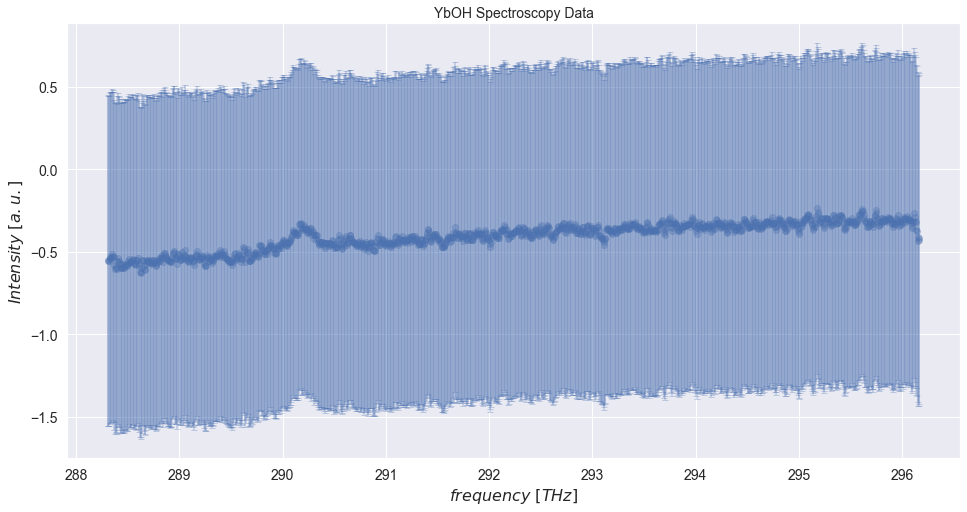

In [7]:
plt.figure(figsize=(16, 8))
plt.errorbar(w, I, fmt='o', yerr=sigma_I, capsize=3, alpha=.3 )
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('YbOH Spectroscopy Data');

In [16]:
model_prior_params = {
                      'A_prior_params': [(0.2, 0.1)],
                      'w0_prior_params': [(290.2, 1)],
                      'gamma_prior_params': [(0.5, 0.1)],
                      'intensity_ratio_prior_params': (.1, .1),
                      'm_prior_params': (0.05, .1),
                      'b_prior_params': (-14.7, .1),
                       # 'c_prior_params': (1e-4, 1e-5)
                      }
# model_prior_params = {
#                       'A_prior_params': [(0.2, 0.1), (-.1, .1), (-.1, .1)],
#                       'w0_prior_params': [(290.2, 0.2), (293.1, .2), (296.1, .2)],
#                       'gamma_prior_params': [(0.5, 0.1), (.1, .05), (.5, .1)],
#                       'intensity_ratio_prior_params': (.1, .1),
#                       'm_prior_params': (0.05, 0.01),
#                       'b_prior_params': (0, 20),
#                        'c_prior_params': (0, 20),
#                       }
fluospec_model_instance = FluoSpecModel(**model_prior_params)

TypeError: __init__() got an unexpected keyword argument 'c_prior_params'

In [9]:
generative_model = fluospec_model_instance.model(real_data)
# generative_model = fluospec_model_instance.model(real_data[:500])

# with generative_model:
#     trace = pm.sample_smc(2000)
#     az.plot_trace(trace)
    # az.plot_trace(trace)
# # 
with generative_model:
    trace = pm.sample(return_inferencedata=True, tune=1000, draws=2000)
    
posterior = trace.posterior.to_dataframe()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, m, intensity_ratio_0, gamma_0, w0_0, A_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.
The acceptance probability does not match the target. It is 0.9054903746085263, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793912126752169, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9009028937851389, but should be close to 0.8. Try to increase the number of tuning steps.


In [17]:
az.plot_trace(trace, var_names=['m', 'b', 'A', 'w0', 'gamma', 'intensity_ratio'])

In [10]:
summary = az.summary(trace, hdi_prob=.95)[0:6]
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.049,0.000,0.048,0.050,0.000,0.000,5170.0,5295.0,1.0
b,-14.701,0.099,-14.898,-14.512,0.001,0.001,5187.0,5037.0,1.0
A_0,0.168,0.075,0.037,0.312,0.001,0.001,6406.0,4248.0,1.0
w0_0,290.185,0.867,288.145,291.856,0.011,0.008,6260.0,3220.0,1.0
gamma_0,0.498,0.099,0.313,0.695,0.001,0.001,8180.0,4866.0,1.0
intensity_ratio_0,0.106,0.103,0.000,0.312,0.001,0.001,5131.0,3153.0,1.0


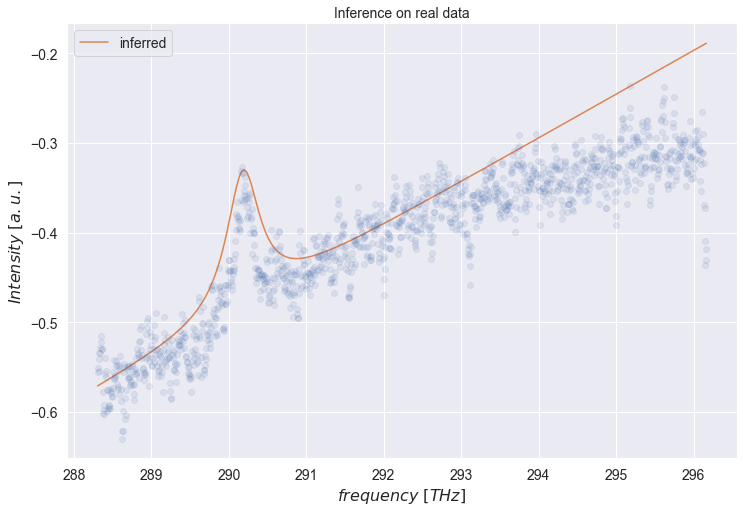

In [15]:
plt.figure(figsize=(12,8))
plt.errorbar(w, I, fmt='o', alpha=.1)
plt.xlabel('$frequency \ [THz]$')
plt.ylabel('$Intensity \ [a.u.]$')
plt.title('Inference on real data');

A_inf = summary['mean']['A_0']
w0_inf = summary['mean']['w0_0']
gamma_inf = summary['mean']['gamma_0']
intensity_ratio_inf = summary['mean']['intensity_ratio_0']
m_inf = summary['mean']['m']
b_inf = summary['mean']['b']

w_inf = np.linspace(real_data.w.min(), real_data.w.max(), 250)

prediction_inferred = Prediction([A_inf], [w0_inf], [gamma_inf], intensity_ratio_inf, m_inf, b_inf).prediction(w_inf)

plt.plot(w_inf, prediction_inferred, label='inferred')
plt.legend();